In [4]:
#Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import*

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

import matplotlib.pyplot as plt
import os
import pandas as pd
#from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model

In [6]:

import random


def set_seed(seed=52):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(52)

In [7]:
train_dir='/kaggle/input/kmc-dataset/KMC/Training'
test_dir='/kaggle/input/kmc-dataset/KMC/Test'
val_dir='/kaggle/input/kmc-dataset/KMC/Validation'

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,           # rotate images up to 20 degrees
    width_shift_range=0.1,       # shift horizontally
    height_shift_range=0.1,      # shift vertically
    zoom_range=0.2,              # random zoom
    shear_range=0.15,            # shear transformation
    horizontal_flip=True,        # flip images horizontally
    fill_mode='nearest',# fill in missing pixels after transformation
    # featurewise_center=True,featurewise_std_normalization=True
)

In [9]:
# For Validation Data - Only rescaling (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# For Test Data - Only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)
# train data

train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    # subset='training'
    shuffle = True
)

# Validation Data
val_data = datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=8,
    class_mode='categorical',
    # subset='validation',
    shuffle = False
)

#test data

test_data = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=1,

    class_mode='categorical',
    shuffle=False
)

Found 3432 images belonging to 5 classes.
Found 503 images belonging to 5 classes.
Found 506 images belonging to 5 classes.


In [10]:
#define multikernel block updated
def mk_block(input, num_filters):
    x1 = Conv2D(num_filters // 4 ,(1,1),padding = 'same')(input)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)

    x2 = SeparableConv2D(num_filters // 4 ,(3,3),padding = 'same')(input)# conv instead of separable conv
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    x2= Conv2D(num_filters // 4 ,(1,1),padding = 'same')(x2) # add 1x1 conv for dimensionality reduction

    x3 = SeparableConv2D(num_filters // 4 ,(5,5),padding = 'same')(input) # conv instead of separable conv
    x3 = BatchNormalization()(x3)
    x3 = Activation('relu')(x3)
    x3=Conv2D(num_filters // 4 ,(1,1),padding = 'same')(x3) # add 1x1 conv for dimensionality reduction

    x4 = SeparableConv2D(num_filters // 4 ,(7,7),padding = 'same')(input) # conv instead of separable conv
    x4 = BatchNormalization()(x4)
    x4 = Activation('relu')(x4)
    x4=Conv2D(num_filters // 4 ,(1,1),padding = 'same')(x4) # add 1x1 conv for dimensionality reduction
    x5=Conv2D(num_filters ,(1,1),padding = 'same')(input) # add 1x1 conv for dimensionality reduction
    x5=BatchNormalization()(x5)

    x = Concatenate()([x1,x2,x3,x4])
    x=Conv2D(num_filters ,(1,1),padding = 'same')(x)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=Concatenate()([x,x5])
    x=Activation('relu')(x)

    return x

In [11]:
# RPAB

def RPAB_block(input,num_filters):
  x1=Conv2D(num_filters,kernel_size=(3,3),padding='same')(input)
  x1=BatchNormalization()(x1)


  x1=Activation('relu')(x1)
  x1=Conv2D(num_filters,kernel_size=(3,3),padding='same')(x1)
  x2=Conv2D(num_filters,kernel_size=(1,1),padding='same')(x1)

  x2=Activation('relu')(x2)

  x2=Conv2D(num_filters,kernel_size=(1,1),padding='same')(x2)
  x2=Activation('sigmoid')(x2)
  x2= Multiply()([x1,x2])
  x2= Add()([x2,input])
  return x2

In [12]:
# define RCAB
def RCAB_block(input,num_filters):
  x1=Conv2D(num_filters,kernel_size=(3,3),padding='same')(input)
  x1=Activation('relu')(x1)
  x1=Conv2D(num_filters,kernel_size=(3,3),padding='same')(x1)
  x2=GlobalAveragePooling2D()(x1)
  x2 = Reshape((1, 1, num_filters))(x2)
  x2=Conv2D(num_filters,kernel_size=(1,1),padding='same')(x2)
  x2=Activation('relu')(x2)
  x2=Conv2D(num_filters,kernel_size=(1,1),padding='same')(x2)
  x2=Activation('sigmoid')(x2)
  x2= Multiply()([x1,x2])
  input = Conv2D(num_filters, kernel_size=(1, 1), padding='same')(input) # add thisnew line
  x2=Add()([x2,input])
  return x2

In [13]:
# define mkrc +rpa+ rca
def mkrc_block(input,num_filters):
  x=mk_block(input,num_filters)
  x1=RCAB_block(x,num_filters)
  x2=RPAB_block(x1,num_filters)

  # x3=Concatenate()([x1,x2])
  x2=Conv2D(num_filters,kernel_size=(1,1),padding='same')(x2)
  x2=BatchNormalization()(x2)
  x2=Activation('relu')(x2)

  return x2


In [14]:
def SE_block(input,num_filters):

    x = GlobalAveragePooling2D()(input)

    x = Dense(num_filters // 16, activation='relu')(x) # Use input channels // 16

    x = Dense(num_filters, activation='sigmoid')(x)

    x = Reshape((1,1,num_filters))(x)

    x = Multiply()([input, x])
    return x

In [15]:
def rfb_block(input, num_filters):
    branch1 = Conv2D(num_filters, (1, 1), padding='same')(input)
    branch1 = BatchNormalization()(branch1)
    branch1 = Activation('relu')(branch1)


    branch2 = Conv2D(num_filters, (1, 1), padding='same', activation='relu')(input)
    branch2 = DepthwiseConv2D((3, 3), dilation_rate=2, padding='same')(branch2)
    branch2=BatchNormalization()(branch2)
    branch2 = Activation('relu')(branch2)
    branch2= SE_block(branch2,num_filters)

    branch3 = Conv2D(num_filters, (1, 1), padding='same', activation='relu')(input)
    branch3 = DepthwiseConv2D((3, 3), dilation_rate=3, padding='same')(branch3)
    branch3=BatchNormalization()(branch3)
    branch3 = Activation('relu')(branch3)
    branch3 = SE_block(branch3,num_filters)

    branch4 = Conv2D(num_filters, (1, 1), padding='same', activation='relu')(input)
    branch4 = DepthwiseConv2D((3, 3), dilation_rate=5, padding='same', activation='relu')(branch4)
    # branch4= Conv2D(num_filters, (1, 1), padding='same', activation='relu')(branch4)
    branch4 = SE_block(branch4,num_filters)
    x = Concatenate()([branch1, branch2, branch3, branch4])
    x = Conv2D(num_filters, (1, 1), padding='same', )(x)
    x= BatchNormalization()(x)
    x= Activation('relu')(x)

    return x

In [16]:
# define model
def ProposedModel(input_shape,classes = 5 ):
  X_input = Input(input_shape)


  x1=Conv2D(16,(3,3),padding='same',strides=(1,1))(X_input)
  x1=BatchNormalization()(x1)
  x1=Activation('relu')(x1)
  x1=Conv2D(16,(3,3),padding='same',strides=(1,1))(x1)
  x1=BatchNormalization()(x1)
  x1=Activation('relu')(x1)
  x=Conv2D(32,(3,3),padding='same',strides=(1,1))(x1)
  x=BatchNormalization()(x)
  x=Activation('relu')(x)
  x1 = Conv2D(32, (1, 1), padding='same')(x1)
  x=Add()([x,x1])
  x=SE_block(x,32)
  x=MaxPooling2D((2,2))(x)



  # x2=SE_block(x1,32)
  x2= rfb_block(x,32) #instead of aspp
  # x2=SE_block(x2,32)
  x2= UpSampling2D((2,2), interpolation = 'bilinear')(x2)

  x3 = Conv2D(64,(3,3),padding='same',strides=(1,1))(x)
  x3 = BatchNormalization()(x3)
  x3 = Activation('relu')(x3)
  x3 = mkrc_block(x3,32)    #instead of cbam
  x3=Add()([x,x3])
  x3=SE_block(x3,32)


  x3 = MaxPooling2D((2,2))(x3)


  # x4=SE_block(x3,32)

  x4 = rfb_block(x3,32)
  # x4=SE_block(x4,32)
  x4 = UpSampling2D((4,4), interpolation = 'bilinear')(x4)

  x5 =Conv2D(64,(3,3),padding='same')(x3)
  x5 = BatchNormalization()(x5)
  x5 = Activation('relu')(x5)
  # add conv and res connection
  x5 = Conv2D(64,(1,1),padding='same')(x5)
  x3 = Conv2D(64, (1, 1), padding='same')(x3)
  x5 = Add()([x5,x3])
  x5 = Activation('relu')(x5)


  x5 = mkrc_block(x5,64)   # instead of cbam
  x5=SE_block(x5,64)
  x5 = MaxPooling2D((2,2))(x5)


  # x6=SE_block(x3,32)
  x6 = rfb_block(x5,64)  #instead of aspp
  # x6=SE_block(x6,64)
  x6 = UpSampling2D((8,8), interpolation = 'bilinear')(x6)


  x7= Concatenate()([x2,x4,x6])

  x7= GlobalAveragePooling2D()(x7)
  x7= Dense(256)(x7)
  x7= BatchNormalization()(x7)
  x7= Activation('relu')(x7)

  x7= Dropout(0.5)(x7)

  x7= Dense(128)(x7)
  x7= BatchNormalization()(x7)
  x7= Activation('relu')(x7)
  


  x7= Dense(classes)(x7)
  x7= Activation('softmax')(x7)

  model = Model(inputs=X_input,outputs=x7)
  return model

In [17]:


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import *
from tensorflow.keras import regularizers
from tensorflow.keras.losses import CategoricalCrossentropy



model = ProposedModel((224,224,3),5)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=CategoricalCrossentropy(label_smoothing=0.01),
              metrics=['accuracy'])
model.summary()



I0000 00:00:1745935392.740114      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745935392.740787      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 224, 224, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 16)   │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 224, 224, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 224, 224, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 224, 224, 32)   │          4,640 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 224, 224, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 224, 224, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 224, 224, 32)   │            544 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 32)   │              0 │ activation_2[0][0],    │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 32)             │              0 │ add[0][0]              │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 2)              │             66 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │             96 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 32)       │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 224, 224, 32)   │              0 │ add[0][0],             │
│                      

 Total params: 477,853 (1.82 MB)

 Trainable params: 474,717 (1.81 MB)

 Non-trainable params: 3,136 (12.25 KB)

In [18]:
model.save('ProposedModel.h5')

In [19]:
model.load_weights('/kaggle/input/weights/model_23_april_new.weights.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 542 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [14]:
# Reduce LR when accuracy plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 mode='max',  # Fix mode
                                                 factor=0.5,
                                                 patience=10,  # Reduce patience to make it adapt faster
                                                 verbose=1,
                                                 cooldown=1,
                                                 min_delta=0.0001,
                                                 min_lr=1e-6)  # Minimum LR limit

# Early stopping to prevent overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              mode='max',
                                              min_delta=0.0001,
                                              patience=20,  # Reduced patience
                                              verbose=1,
                                              restore_best_weights=True)

# Model checkpoint for best weights
check_path = '/kaggle/working/model_23_april_new.weights.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=check_path,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                save_weights_only=True,
                                                mode='max')

# Train model with improved batch size
history = model.fit(train_data,
                    validation_data=val_data,
                    batch_size=8,
                    shuffle=True,
                    verbose=1,
                    epochs=100,
                    callbacks=[reduce_lr, early_stop, checkpoint])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745399484.572405     115 service.cc:148] XLA service 0x7c74e8002da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745399484.573466     115 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745399484.573485     115 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745399489.802699     115 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745399523.424135     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.4421 - loss: 1.3484
Epoch 1: val_accuracy improved from -inf to 0.28032, saving model to /kaggle/working/model_23_april_new.weights.h5
429/429 ━━━━━━━━━━━━━━━━━━━━ 186s 211ms/step - accuracy: 0.4423 - loss: 1.3480 - val_accuracy: 0.2803 - val_loss: 1.5113 - learning_rate: 1.0000e-04
Epoch 2/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.6626 - loss: 0.8909
Epoch 2: val_accuracy improved from 0.28032 to 0.72565, saving model to /kaggle/working/model_23_april_new.weights.h5
429/429 ━━━━━━━━━━━━━━━━━━━━ 68s 157ms/step - accuracy: 0.6626 - loss: 0.8909 - val_accuracy: 0.7256 - val_loss: 0.9755 - learning_rate: 1.0000e-04
Epoch 3/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7125 - loss: 0.7566
Epoch 3: val_accuracy did not improve from 0.72565
429/429 ━━━━━━━━━━━━━━━━━━━━ 67s 154ms/step - accuracy: 0.7126 - loss: 0.7565 - val_accuracy: 0.3400 - val_loss: 5.0758 - learning_rate: 1.0000e-04
Epoch 4/100
429/

In [17]:
class_names = list(test_data.class_indices.keys())
print(class_names)
test_predictions = model.predict(test_data)
test_pred = np.argmax(test_predictions, axis=1)
test_true =test_data.classes

['grade0', 'grade1', 'grade2', 'grade3', 'grade4']
506/506 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step


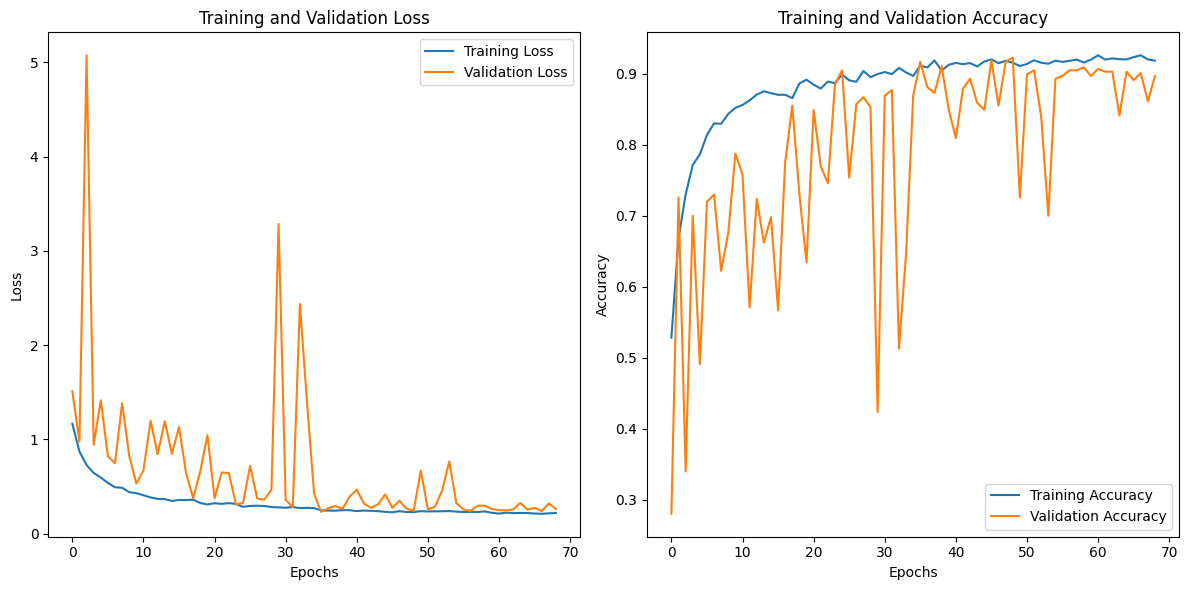

In [18]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [24]:
from tensorflow import keras

model = keras.models.load_model('/kaggle/working/ProposedModel.h5')

In [20]:
model.load_weights('/kaggle/input/weights/model_23_april_new.weights.h5')

In [22]:
val_loss, val_acc = model.evaluate(val_data)
print(f"Validation accuracy: {val_acc*100:.2f}%")


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.9590 - loss: 0.1696
Validation accuracy: 92.64%


In [23]:
class_names = list(test_data.class_indices.keys())
print(class_names)
test_predictions = model.predict(test_data)
test_pred = np.argmax(test_predictions, axis=1)
test_true =test_data.classes



from sklearn.metrics import classification_report,confusion_matrix
print("Performance Metrics: ")
metrics = classification_report(test_true,test_pred,target_names=class_names)
print(metrics)
print("Confusion Matrix: ")
CM = confusion_matrix(test_true, test_pred)
print(CM)

['grade0', 'grade1', 'grade2', 'grade3', 'grade4']
506/506 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step
Performance Metrics: 
              precision    recall  f1-score   support

      grade0       1.00      0.99      1.00       102
      grade1       0.90      0.99      0.94       107
      grade2       0.95      0.75      0.84        96
      grade3       0.83      0.98      0.90       105
      grade4       1.00      0.91      0.95        96

    accuracy                           0.93       506
   macro avg       0.94      0.92      0.92       506
weighted avg       0.93      0.93      0.93       506

Confusion Matrix: 
[[101   0   1   0   0]
 [  0 106   1   0   0]
 [  0  12  72  12   0]
 [  0   0   2 103   0]
 [  0   0   0   9  87]]


In [24]:
test_d = ImageDataGenerator(rescale=1. / 255)
test = test_d.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=1,
    shuffle = False,
    class_mode='categorical')








import numpy as np

test_step = test_data.n//test_data.batch_size
test_data.reset()
pred = model.predict(test_data , steps = test_step , verbose = 1)

pred_class_indices = np.argmax(pred,axis=1)

## printing predicted labels
print(pred_class_indices)

from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score,jaccard_score,classification_report
from sklearn.metrics import precision_score,recall_score,jaccard_score
classes = [0,1,2,3,4]

print(len(pred_class_indices))
print(len(test_data.labels))
for cl in classes:

    print("class: ",cl)

    a1 = np.uint8(test.labels == cl)
    a2 = np.uint8(pred_class_indices == cl)

    print('Accuracy {}'.format(accuracy_score(y_true=a1, y_pred=a2)))
    print('F1 {}'.format(f1_score(y_true=a1, y_pred=a2)))
    print('precision {}'.format(precision_score(y_true=a1, y_pred=a2)))
    print('recall {}'.format(recall_score(y_true=a1, y_pred=a2)))

    print('jaccard {}'.format(jaccard_score(y_true=a1, y_pred=a2)))
    print("_")


print('Accuracy {}'.format(accuracy_score(y_true=test.labels, y_pred=pred_class_indices)))
print('F1 {}'.format(f1_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('precision {}'.format(precision_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('recall {}'.format(recall_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))

print('jaccard {}'.format(jaccard_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('confusion_matrix\n {}'.format(confusion_matrix(y_true=test.labels, y_pred=pred_class_indices)))
print('classification_report\n {}'.format(classification_report(y_true=test.labels, y_pred=pred_class_indices)))
print('\n\n')

Found 506 images belonging to 5 classes.
506/506 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 3 3 3 3 2 2 2 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 3 3 2 2 2 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 2 2 2 1 1 1 1 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 